Building level 3D representation

Link of dataset to download: https://mavsuta-my.sharepoint.com/:f:/g/personal/sxs9216_mavs_uta_edu/Eh0qmchvCbBPlwf4ewW_VYsBqSNGzqnAqpAgK0D2TW_PIA?e=hCH6JZ

There might be error if the path of directory images is not right.

In [1]:
import cv2
import numpy as np
import os
from skimage.color import rgb2lab, deltaE_cie76
from sklearn.cluster import KMeans
from skimage import color, feature, io
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
def match_templates(main_image_path, template_folder, output_folder, output_file_path ,threshold):
    # Load the main image
    main_image = cv2.imread(main_image_path, 0)

    # Check if the main image has been loaded correctly
    if main_image is None:
        raise ValueError("Could not load the main image.")

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Initialize a list to store matched labels
    matched_labels = []

    # Iterate through each template in the specified folder
    for template_file in os.listdir(template_folder):
        template_path = os.path.join(template_folder, template_file)

        # Load the template image
        template = cv2.imread(template_path, 0)

        # Check if the template has been loaded correctly
        if template is None:
            print(f"Could not load template: {template_file}")
            continue

        # Template matching
        res = cv2.matchTemplate(main_image, template, cv2.TM_CCOEFF_NORMED)

        # Find all locations where the match probability is above the threshold
        loc = np.where(res >= threshold)

        # If matches are found, add the label to the list of matched labels
        if len(loc[0]) > 0:
            matched_labels.append(template_file)

        # Create bounding boxes around all the matches and label them with the template name
        for pt in zip(*loc[::-1]):
            bottom_right = (pt[0] + template.shape[1], pt[1] + template.shape[0])
            cv2.rectangle(main_image, pt, bottom_right, 255, 2)  # Draw a white rectangle with thickness 2
            cv2.putText(main_image, template_file.split('_')[0], (pt[0], pt[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 2)

    # Save the result
    output_path = os.path.join(output_folder, output_file_path)
    cv2.imwrite(output_path, main_image)

    return output_path, matched_labels

In [3]:
# Extract information from the map
# Number of stories and building_type
def get_stories_building_type(instances):
  building_type = ['D','F','Auto']
  num_stories =['1','1.5','2','2.5','3']
  # if set default value to 1 storie building and building type to be empty
  stories,building = 1," "
  for i in instances:
    if i in num_stories:
      stories = float(i)
    elif i in building_type:
      building = i
    else:
      stories = 1
      building = ''
  print(stories,building)
  return (stories,building)

In [4]:
def identify_color(image_path):
  # Load the image
  image = io.imread(image_path)
  # Convert to LAB color space
  lab_image = rgb2lab(image)

  # Reshape the image to be a list of pixels
  pixels = lab_image.reshape((-1, 3))

  # Use KMeans to find clusters of pixel colors
  # We assume that one of the dominant colors will be the building color (yellow here)
  kmeans = KMeans(n_clusters=3)
  kmeans.fit(pixels)
  cluster_centers = kmeans.cluster_centers_

  # Convert the cluster centers back to RGB to visualize the colors
  centers_rgb = color.lab2rgb(cluster_centers.reshape((1, -1, 3)))

  # Plot the colors as a palette
  plt.figure(figsize=(12, 2))
  plt.imshow(centers_rgb)
  plt.title('Color Palette')
  plt.axis('off')
  plt.show()

  # The color of the building can often be deduced from the palette
  # We will find the dominant color that is closest to pure yellow in the LAB space
  pure_yellow_lab = rgb2lab(np.array([[[255, 255, 0]]], dtype='uint8'))[0][0]

  # Calculate the Euclidean distance of each cluster center to pure yellow
  distances_to_yellow = deltaE_cie76(pure_yellow_lab, cluster_centers)

  # The cluster center closest to pure yellow is assumed to be the building color
  building_color_index = np.argmin(distances_to_yellow)
  building_color_lab = cluster_centers[building_color_index]

  # Show the identified building color
  identified_color_rgb = color.lab2rgb(building_color_lab.reshape((1, 1, 3)))

  plt.figure(figsize=(2, 2))
  plt.imshow(identified_color_rgb)
  plt.title('Identified Building Color')
  plt.axis('off')
  plt.show()

  # Extract the RGB values from the identified_color_rgb array
  identified_color_rgb_values = identified_color_rgb.squeeze().reshape(3)

  # Convert the values to integers (assuming the color is in the range [0, 1])
  identified_color_rgb_int = (identified_color_rgb_values * 255).astype(int)

  print("Identified Color (RGB):", identified_color_rgb_int)
  return identified_color_rgb_int

In [5]:
def plot_in_3D(original_image, stories, identified_color_rgb_int, save_path=None):
    image = io.imread(original_image)

    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)

    # Detect the edges using the Canny detector
    edges = feature.canny(gray_image)

    # Subplot for the original image
    fig, ax0 = plt.subplots(figsize=(7, 7))
    ax0.imshow(image)
    ax0.set_title('Processed Image')
    ax0.axis('off')

    # Save the figure as an image if save_path is provided
    if save_path:
        plt.savefig(save_path.replace('.png', '_original.png'), dpi=300, bbox_inches='tight')

    plt.show()

    # Generate x and y coordinates that correspond to the edges
    # We'll use the indices of the edge pixels as (x, y) coordinates
    x_coords, y_coords = np.where(edges)

    # Define the height of the buildings as 2 units, assuming 1 story
    z_coords = np.ones_like(x_coords) * 2 * stories  # All buildings are 1 story high

    # Use the identified building color for the buildings
    building_color_rgb_int = identified_color_rgb_int  # Replace with the identified RGB values
    building_color_rgb_normalized = building_color_rgb_int / 255.0  # Normalize to [0, 1] range
    building_color_rgb = np.tile(building_color_rgb_normalized, (len(x_coords), 1))  # Repeat for all buildings

    # Plot the edges in 3D for the top view with the identified building color
    fig, ax1 = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(7, 7))
    ax1.bar3d(x_coords, y_coords, np.zeros_like(z_coords), 1, 1, z_coords, color=building_color_rgb, shade=True)
    ax1.set_xlabel('X Coordinates')
    ax1.set_ylabel('Y Coordinates')
    ax1.set_zlabel('Z Axis - Height')
    ax1.set_title('Top View')
    ax1.view_init(elev=90, azim=0)  # Adjust the viewing angle for top view

    # Save the figure as an image if save_path is provided
    if save_path:
        plt.savefig(save_path.replace('.png', '_top_view.png'), dpi=300, bbox_inches='tight')

    plt.show()

    # Plot the edges in 3D for the diagonal view with the identified building color
    fig, ax2 = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(7, 7))
    ax2.bar3d(x_coords, y_coords, np.zeros_like(z_coords), 1, 1, z_coords, color=building_color_rgb, shade=True)
    ax2.set_xlabel('X Coordinates')
    ax2.set_ylabel('Y Coordinates')
    ax2.set_zlabel('Z Axis - Height')
    ax2.set_title('Diagonal View')
    ax2.view_init(elev=45, azim=20)  # Adjust the viewing angle for diagonal view

    # Save the figure as an image if save_path is provided
    if save_path:
        plt.savefig(save_path.replace('.png', '_diagonal_view.png'), dpi=300, bbox_inches='tight')

    plt.show()


Could not load template: .ipynb_checkpoints
Result saved at: output/template_matched_image_labeled_1_building.png
Matched labels: {'D', '1'}
1.0 D


/home/sriks/Computer_Vision/1002059216/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


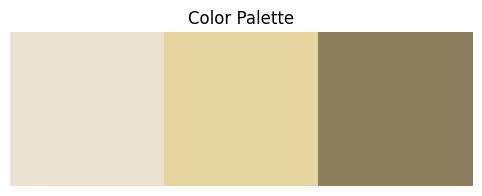

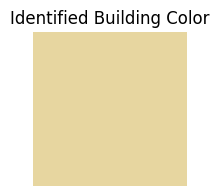

Identified Color (RGB): [231 214 160]


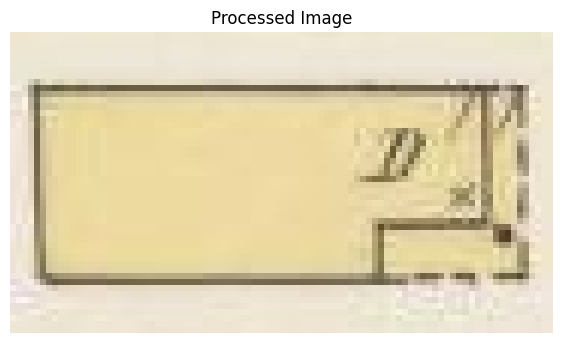

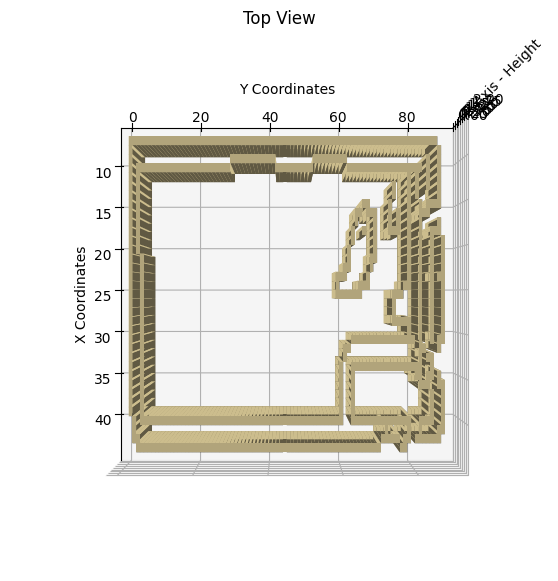

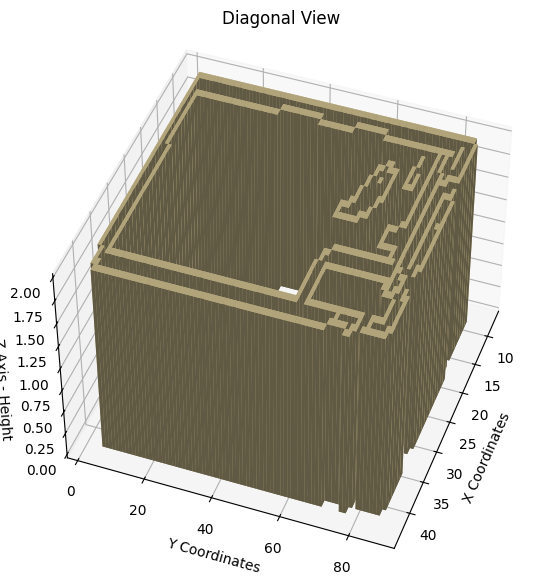

In [9]:
# Path containing target image to be converted to 3D
original_image_path = './images_cv/1_building.jpg'
# Directory containings  template images
template_folder = './templates'
# Folder to save the output image
output_folder = 'output'
threshold = 0.8
output_file_path = 'template_matched_image_labeled_1_building.png'
result, labels = match_templates(original_image_path, template_folder, output_folder, output_file_path,threshold)

# Split based on '_' and extract the instances
instances = set(name.split('_')[0] for name in labels)

print(f"Result saved at: {result}")
print(f"Matched labels: {instances}")

stories,buildings = get_stories_building_type(instances)

color_of_building = identify_color(original_image_path)

plot_in_3D(original_image_path,stories,color_of_building,save_path="./output/3D_1_building.jpg")

Could not load template: .ipynb_checkpoints
Result saved at: output/template_matched_image_labeled_3_building.png
Matched labels: {'D', '2', '1'}
1.0 D


/home/sriks/Computer_Vision/1002059216/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


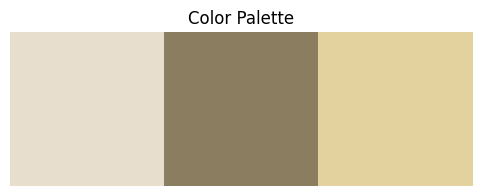

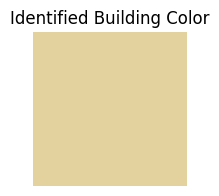

Identified Color (RGB): [227 209 158]


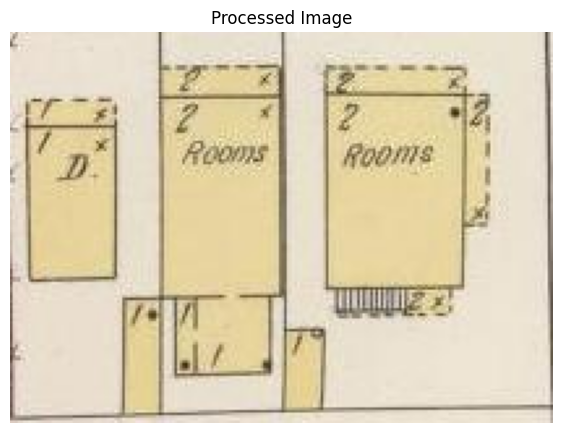

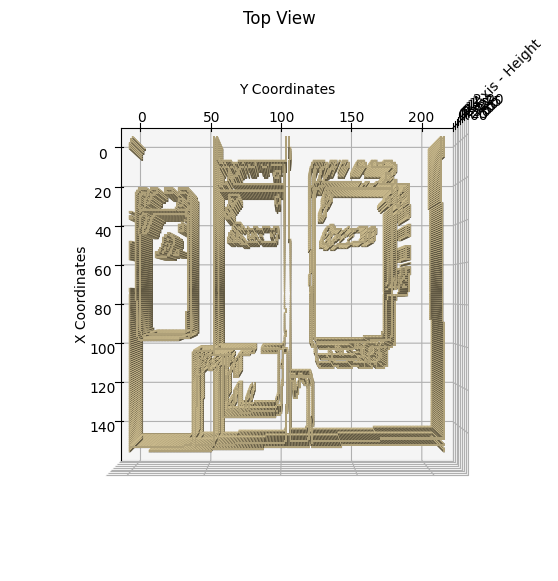

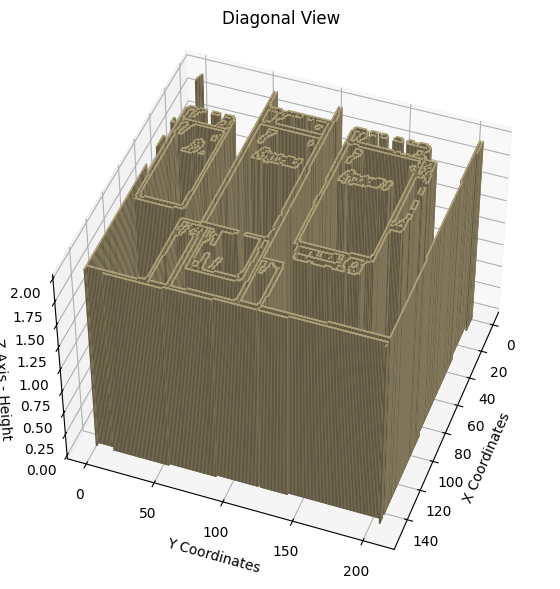

In [10]:
# Example usage
original_image_path = './images_cv/3_buildings.jpg'
# Directory containing template images
template_folder = './templates'
# Directory to save the output image
output_folder = 'output'
threshold = 0.8
output_file_path = 'template_matched_image_labeled_3_building.png'
result, labels = match_templates(original_image_path, template_folder, output_folder, output_file_path,threshold)

# Split based on '_' and extract the instances
instances = set(name.split('_')[0] for name in labels)

print(f"Result saved at: {result}")
print(f"Matched labels: {instances}")

stories,buildings = get_stories_building_type(instances)

color_of_building = identify_color(original_image_path)

plot_in_3D(original_image_path,stories,color_of_building,save_path="./output/3D_3_buildings.jpg")

Could not load template: .ipynb_checkpoints
Result saved at: output/template_matched_image_labeled_4_building.png
Matched labels: {'S', 'D', '2', '1'}
1.0 D


/home/sriks/Computer_Vision/1002059216/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


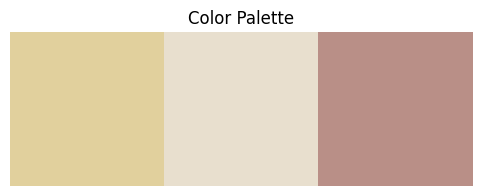

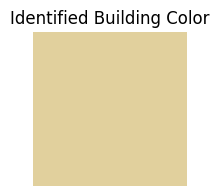

Identified Color (RGB): [225 208 157]


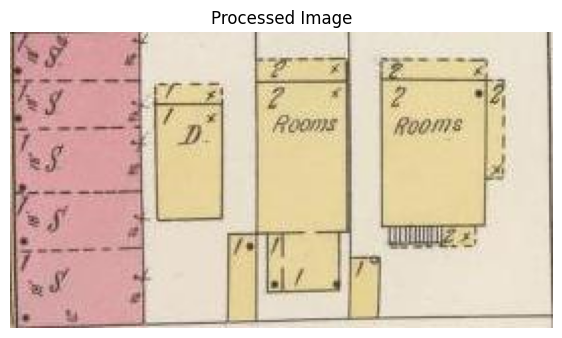

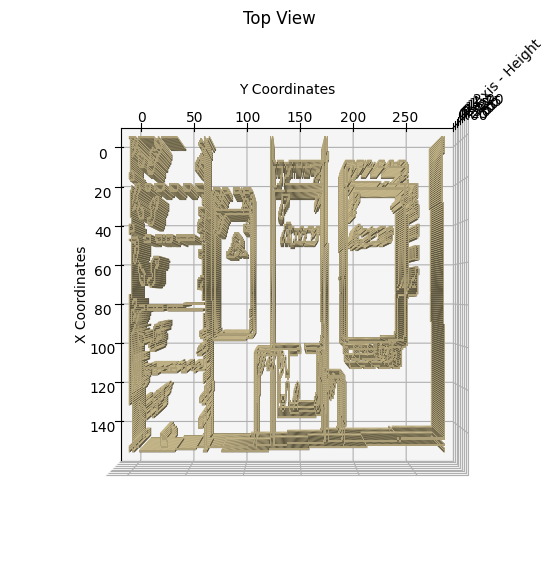

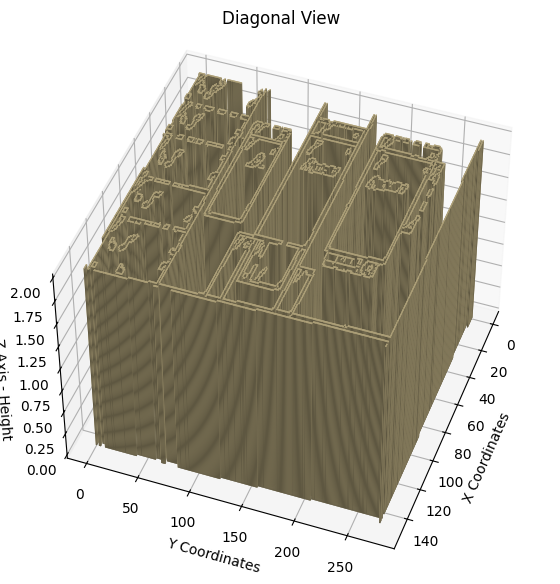

In [11]:
# Example usage
original_image_path = './images_cv/4_buildings.jpg'
# Directory containing template images
template_folder = './templates'
# Directory to save the output image
output_folder = 'output'
threshold = 0.8
output_file_path = 'template_matched_image_labeled_4_building.png'
result, labels = match_templates(original_image_path, template_folder, output_folder, output_file_path,threshold)

# Split based on '_' and extract the instances
instances = set(name.split('_')[0] for name in labels)

print(f"Result saved at: {result}")
print(f"Matched labels: {instances}")

stories,buildings = get_stories_building_type(instances)

color_of_building = identify_color(original_image_path)

plot_in_3D(original_image_path,stories,color_of_building,save_path='./output/3D_4_buildings.jpg')

Could not load template: .ipynb_checkpoints
Result saved at: output/template_matched_image_labeled_small_neighbourhood.png
Matched labels: {'D', '1.5', '1'}
1.0 D


/home/sriks/Computer_Vision/1002059216/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


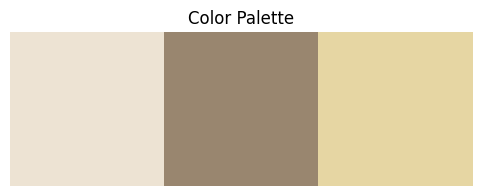

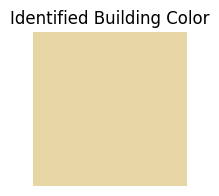

Identified Color (RGB): [230 214 163]


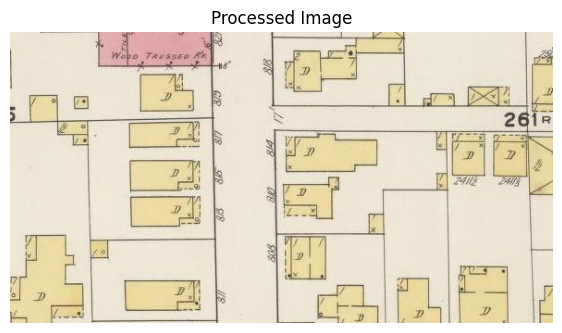

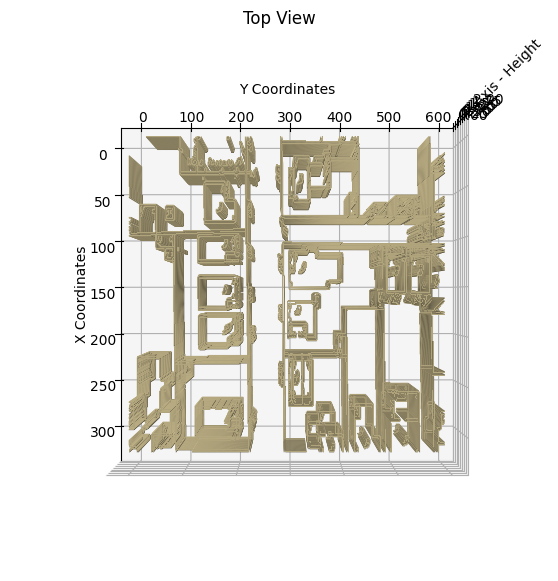

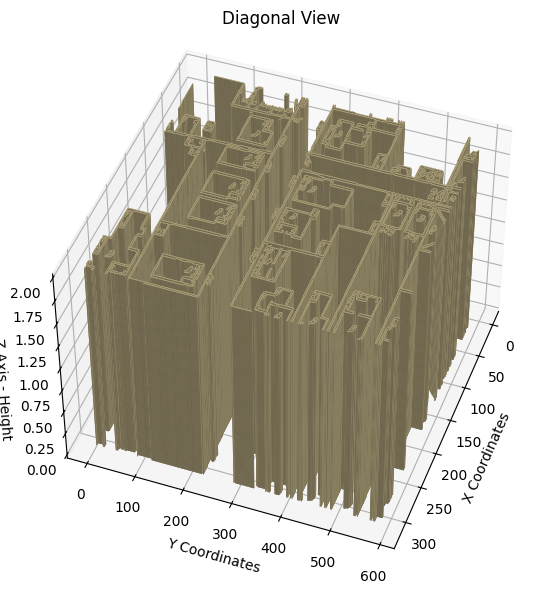

In [12]:
# Example usage
original_image_path = './images_cv/small_neighbourhood.jpg'
# Directory containing template images
template_folder = './templates'
# Directory to save the output image
output_folder = 'output'
threshold = 0.8
output_file_path = 'template_matched_image_labeled_small_neighbourhood.png'
result, labels = match_templates(original_image_path, template_folder, output_folder, output_file_path,threshold)

# Split based on '_' and extract the instances
instances = set(name.split('_')[0] for name in labels)

print(f"Result saved at: {result}")
print(f"Matched labels: {instances}")

stories,buildings = get_stories_building_type(instances)

color_of_building = identify_color(original_image_path)

plot_in_3D(original_image_path,stories,color_of_building,save_path="./output/3D_small_neighbourhood.jpg")

In [ ]:
# import cv2
# import numpy as np

# def canny_edge_detection(image, low_threshold, high_threshold):
#     # Step 1: Convert the image to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Step 2: Apply Gaussian blur to the grayscale image
#     blurred = cv2.GaussianBlur(gray, (5, 5), 0)

#     # Step 3: Compute the gradient using the Sobel operator
#     sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
#     sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

#     # Step 4: Compute the magnitude and direction of the gradient
#     gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
#     gradient_direction = np.arctan2(sobel_y, sobel_x)

#     # Step 5: Non-maximum suppression
#     non_max_suppressed = np.zeros_like(gradient_magnitude)
#     angle_quantized = (np.round(gradient_direction * (4.0 / np.pi)) % 4).astype(int)

#     for i in range(1, gradient_magnitude.shape[0] - 1):
#         for j in range(1, gradient_magnitude.shape[1] - 1):
#             if angle_quantized[i, j] == 0:  # 0 degrees (horizontal)
#                 non_max_suppressed[i, j] = (gradient_magnitude[i, j] == max(
#                     gradient_magnitude[i, j - 1], gradient_magnitude[i, j + 1]))
#             elif angle_quantized[i, j] == 1:  # 45 degrees (diagonal)
#                 non_max_suppressed[i, j] = (gradient_magnitude[i, j] == max(
#                     gradient_magnitude[i - 1, j - 1], gradient_magnitude[i + 1, j + 1]))
#             elif angle_quantized[i, j] == 2:  # 90 degrees (vertical)
#                 non_max_suppressed[i, j] = (gradient_magnitude[i, j] == max(
#                     gradient_magnitude[i - 1, j], gradient_magnitude[i + 1, j]))
#             elif angle_quantized[i, j] == 3:  # 135 degrees (diagonal)
#                 non_max_suppressed[i, j] = (gradient_magnitude[i, j] == max(
#                     gradient_magnitude[i - 1, j + 1], gradient_magnitude[i + 1, j - 1]))

#     # Step 6: Apply double thresholding and edge tracking by hysteresis
#     edges = np.zeros_like(gradient_magnitude)
#     weak_edge, strong_edge = 50, 150  # Threshold values

#     strong_pixels = (gradient_magnitude > high_threshold)
#     weak_pixels = (gradient_magnitude >= low_threshold) & (gradient_magnitude <= high_threshold)

#     edges[strong_pixels] = 255
#     edges[weak_pixels] = 25  # Mark weak edges

#     # Edge tracking by hysteresis
#     for i in range(1, gradient_magnitude.shape[0] - 1):
#         for j in range(1, gradient_magnitude.shape[1] - 1):
#             if edges[i, j] == 25:
#                 neighbors = edges[i-1:i+2, j-1:j+2]
#                 if np.any(neighbors == 255):
#                     edges[i, j] = 255

#     return edges.astype(np.uint8)

# # Read an image from file
# image_path = '/content/drive/MyDrive/images_cv/1_building.jpg'
# original_image = cv2.imread(image_path)

# # Perform Canny edge detection
# edges = canny_edge_detection(original_image, low_threshold=50, high_threshold=150)

# plt.imshow(edges)